#LSTM Model For Physical Health

In [ ]:
import numpy as np
import pandas as pd
import pickle
from math import pi
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,LSTM,Dropout,Dense,TimeDistributed,Input,Reshape


## Training The Model

In [ ]:
#initializing mental risks
physical_risks_list = ['diabetes type 2','physically healthy','heart diseases',
                     'stroke','lung disorder','body pain','indigation','cancer','prediabetes']

# create the training data
path_list = ["/content/physical_health_data_year-1.csv","/content/physical_health_data_year-2.csv",
             "/content/physical_health_data_year-3.csv","/content/physical_health_data_year-4.csv","/content/physical_health_data_year-5.csv"]


In [ ]:
# sample dataframe
df = pd.read_csv(path_list[0])

traindf = pd.DataFrame("", index=range(0,len(df)),columns=df.columns)

for i in range(0,len(path_list)):
  data = pd.read_csv(path_list[i])

  for col in data.columns:
    traindf[col] += data[col]+","

traindf.to_csv("physical_health_training.csv",index=False)


In [ ]:
traindf.head()

,Health Conditions,Lifestyle,Workstyles,Chronic Conditions
0,"age, cholesterol, prediabetes, genetic, obesi...","stress, financial pressure,inactivity, poor d...","shift work, less relax, work stress, posture,...","heart diseases,diabetes type 2,body pain,predi..."
1,"obesity,regular health checkup, regular healt...","smoking, inactivity, humour, pollution, pollut...",NaN,"body pain,physically healthy,lung disorder,lun..."
2,"genetic, genetic, obesity, obesity, obesity, ...","smoking, less sleep, inactivity,smoking, poor ...",NaN,"lung disorder,indigation,body pain,diabetes ty..."
3,"cholesterol,genetic, genetic, age,diabetes, o...","irregular sleep, financial pressure, inactivi...",", posture, posture, overtime,shift work,less ...","heart diseases,body pain,cancer,indigation,bod..."
4,"genetic, asthema, age, obesity, genetic, gene...","pollution,smoking,age, poor diet, irregular s...",NaN,"lung disorder,cancer,prediabetes,body pain,str..."


In [ ]:
# editing the data
def clean_text(traindf):

  for col in traindf.columns:
    for row in range(len(traindf)):
      try:
        traindf.iloc[row][col] = traindf.iloc[row][col].replace(", ", ",")
        
        # remove spaces from both end of string
        traindf.iloc[row][col] = traindf.iloc[row][col].strip(" ")

        # replace " " with "_"
        traindf.iloc[row][col] = traindf.iloc[row][col].replace(" ", "_")
      except AttributeError:
        break
  
  return traindf


In [ ]:
traindf = traindf.fillna("")

traindf = clean_text(traindf)
traindf.head()

,Health Conditions,Lifestyle,Workstyles,Chronic Conditions
0,"age,cholesterol,prediabetes,genetic,obesity,ge...","stress,financial_pressure,inactivity,poor_diet...","shift_work,less_relax,work_stress,posture,less...","heart_diseases,diabetes_type_2,body_pain,predi..."
1,"obesity,regular_health_checkup,regular_health_...","smoking,inactivity,humour,pollution,pollution,...",,"body_pain,physically_healthy,lung_disorder,lun..."
2,"genetic,genetic,obesity,obesity,obesity,obesit...","smoking,less_sleep,inactivity,smoking,poor_die...",,"lung_disorder,indigation,body_pain,diabetes_ty..."
3,"cholesterol,genetic,genetic,age,diabetes,obesi...","irregular_sleep,financial_pressure,inactivity,...",", posture, posture, overtime,shift work,less ...","heart_diseases,body_pain,cancer,indigation,bod..."
4,"genetic,asthema,age,obesity,genetic,genetic,ea...","pollution,smoking,age,poor_diet,irregular_slee...",,"lung_disorder,cancer,prediabetes,body_pain,str..."


In [ ]:
#input consists of health, lifestyle and workstyle
inp = list()

for hm, lm, wm in zip(traindf['Health Conditions'],traindf['Lifestyle'],traindf['Workstyles']):
  health = [w for w in hm.split(",")]
  health.pop(-1)

  lstyle = [w for w in lm.split(",")]
  lstyle.pop(-1)

  wstyle = [w for w in wm.split(",")]
  wstyle.pop(-1)

  inp.append(health + lstyle + wstyle) 

#output consists of possible mental risks
mental_risk = list()

for m in traindf['Chronic Conditions']:
  risks = [w for w in m.split(",")]
  risks.pop(-1)

  mental_risk.append(risks)


In [ ]:
MAX_LEN = 30

#inp tokenizer for input data
inp_token = Tokenizer()
inp_token.fit_on_texts(inp)
inp_dict = inp_token.word_index

xseq = inp_token.texts_to_sequences(inp)
xpadseq = pad_sequences(xseq,maxlen=MAX_LEN,padding='post')

#output tokenizer for output data
out_token = Tokenizer()
out_token.fit_on_texts(mental_risk)
out_dict = out_token.word_index

yseq = out_token.texts_to_sequences(mental_risk)
ypadseq = pad_sequences(yseq,maxlen=MAX_LEN,padding='post')

print([xpadseq[0],ypadseq[0]])


[array([ 9, 20, 29,  3,  2,  3, 37, 41, 26,  6,  4,  1,  1, 45, 45, 52, 51,
       50, 53, 51, 50, 50, 35, 35,  0,  0,  0,  0,  0,  0], dtype=int32), array([5, 2, 3, 8, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)]


In [ ]:
vocab = len(inp_dict) + 1
num_classes = len(out_dict) + 1

yvec = tf.keras.utils.to_categorical(ypadseq,num_classes=num_classes)

model = tf.keras.models.Sequential([
    Embedding(vocab,256,input_length=MAX_LEN),

    Dropout(0.2),

    LSTM(256,input_shape=(MAX_LEN,1),return_sequences=True),
    LSTM(256,input_shape=(MAX_LEN,1),return_sequences=True),

    TimeDistributed(Dense(units=num_classes,activation=tf.nn.softmax))
])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 256)           13824     
_________________________________________________________________
dropout (Dropout)            (None, 30, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 256)           525312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 10)            2570      
Total params: 1,067,018
Trainable params: 1,067,018
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reduced_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    min_lr=1e-9,
    patience=3,
    cooldown=1
)
model.compile(loss="categorical_crossentropy",optimizer='rmsprop',metrics=["accuracy"])

history = model.fit(xpadseq,yvec,epochs=10,callbacks=[reduced_lr],verbose=1,batch_size=8)

Epoch 1/10
63/63 [==============================] - 15s 181ms/step - loss: 0.4699 - accuracy: 0.8280
Epoch 2/10
63/63 [==============================] - 11s 182ms/step - loss: 0.3879 - accuracy: 0.8521
Epoch 3/10
63/63 [==============================] - 12s 183ms/step - loss: 0.3785 - accuracy: 0.8549
Epoch 4/10
63/63 [==============================] - 12s 185ms/step - loss: 0.3726 - accuracy: 0.8566
Epoch 5/10
63/63 [==============================] - 12s 185ms/step - loss: 0.3730 - accuracy: 0.8575
Epoch 6/10
63/63 [==============================] - 12s 183ms/step - loss: 0.3662 - accuracy: 0.8594
Epoch 7/10
63/63 [==============================] - 12s 183ms/step - loss: 0.3605 - accuracy: 0.8643
Epoch 8/10
63/63 [==============================] - 12s 183ms/step - loss: 0.3534 - accuracy: 0.8671
Epoch 9/10
63/63 [==============================] - 11s 182ms/step - loss: 0.3438 - accuracy: 0.8696
Epoch 10/10
63/63 [==============================] - 11s 183ms/step - loss: 0.3390 - accura

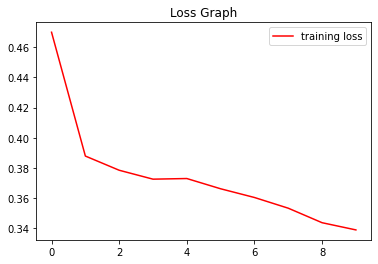

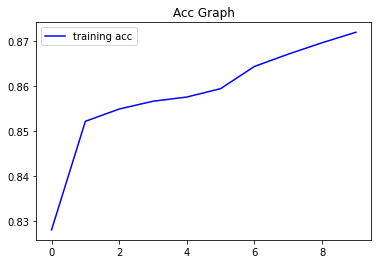

In [ ]:
loss = history.history['loss']
acc = history.history['accuracy']

epoch = range(len(loss))

plt.plot(epoch,loss,'r',label='training loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()
plt.plot(epoch,acc,'b',label='training acc')
plt.title('Acc Graph')
plt.legend()
plt.show()


In [ ]:
# storing the model parameters
model.save("ph_lstm_model.h5")

# input dictionary
dfile = open("ph_inp_dict.pkl",'wb')
pickle.dump(inp_dict, dfile)
dfile.close()

# output dictionary
dfile = open("ph_out_dict.pkl",'wb')
pickle.dump(out_dict, dfile)
dfile.close()


## Loading model and testing outputs

In [ ]:
# loading all the model files
model = tf.keras.models.load_model("/content/ph_lstm_model.h5")

dfile = open("/content/ph_inp_dict.pkl", "rb")
inp_dict = pickle.load(dfile)

dfile = open("/content/ph_out_dict.pkl", "rb")
out_dict = pickle.load(dfile)


In [ ]:
test_case_1 = {
        "Health": ["obesity, diabetes, cholesterol, cholesterol, prediabetes"],
        "Lifestyle": ["poor diet, irregular sleep, less sleep, smoking, smoking, smoking, pollution"],
        "Work Style": ["work stress, work stress, work stress"]
}

test_case_2 = {
        "Health": ["anxiety, high blood pressure, hormonal imbalance, vitamin deficiency, thyroid, hormonal imbalance, thyroid, post traumatic stress"],
        "Lifestyle": ["alcohol, drug abuse, poor diet, stress, irregular sleep, confused, panic, high screen time, poor diet, hypnosis, day dream, fake emotions"],
        "Work Style": ["overtime, work stress, repeating tasks, improper recognition, work stress, work relations, overtime, negative work relations, repeating tasks"]
}

test_case_3 = {
        "Health": ["post traumatic stress, chronic pain, ocd, thyroid, diabetes, heart disorder"],
        "Lifestyle": ["history of abuse, low self esteem, high screen time, family, lack of relationships, negative social connection"],
        "Work Style": ["work stress, underperformer, introvert, incomplete tasks"]
}

test_case_4 = {
        "Health": [""],
        "Lifestyle": ["alcohol, drug abuse, poor diet"],
        "Work Style": ["work stress, underperformer, introvert"]
}


In [ ]:
MAX_LEN = 30

# creating testing text
testdf = pd.DataFrame(test_case_1)

testdf = clean_text(testdf)

# encoding new text with inp dictionary
testinp = list()

for hm, lm, wm in zip(testdf['Health'],testdf['Lifestyle'],testdf['Work Style']):
  health = [w for w in hm.split(",")]
  health.pop(-1)

  lstyle = [w for w in lm.split(",")]
  lstyle.pop(-1)

  wstyle = [w for w in wm.split(",")]
  wstyle.pop(-1)

  testinp.append(health + lstyle + wstyle) 

# initializing the tokenizer with pre-built dictionary
test_token = Tokenizer()
test_token.word_index = inp_dict
xseq = test_token.texts_to_sequences(testinp)
xpadseq = pad_sequences(xseq,maxlen=MAX_LEN,padding='post')

# predicting the output
predicted = model.predict(xpadseq)
final_list = list()

for i in range(len(predicted)):
  res = list()
  pred = np.round( np.argmax(predicted[i],axis=1) )

  for w in pred:
    for word, index in out_dict.items():
      if index == w:
        res.append(word)
        break
    
  final_list.append(res)


In [ ]:
final_list

[['body_pain', 'stroke', 'diabetes_type_2', 'diabetes_type_2', 'body_pain']]

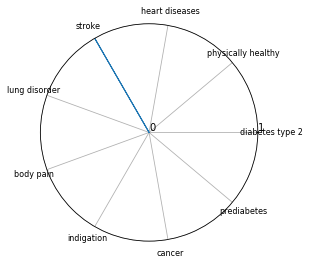

In [ ]:
# the score dictionary
score_dict = dict()

N = len(physical_risks_list)

for risk in physical_risks_list:
  score_dict[risk] = 0

for risk in final_list[0]:
  for key in score_dict.keys():
    if key == risk:
      score_dict[key] += 1    

angles = [n / float(N) * 2 * pi for n in range(N)]

values = list(score_dict.values())
categories = list(score_dict.keys())

ax = plt.subplot(111, polar=True)
plt.xticks(angles, categories, color='black', size=8)

max_idx = max(score_dict, key=score_dict.get)
max_value = score_dict[max_idx]

ax.set_rlabel_position(0)
plt.yticks(list( range(0,(max_value + 1)) ), [str(n) for n in list( range(0,(max_value + 1)) )], color="black", size=10)
plt.ylim(0,max_value)

ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.fill(angles, values, 'b', alpha=0.1)

plt.show()
